In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [39]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()

In [17]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

In [18]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
Station = base.classes.station
Measurement = base.classes.measurement

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [30]:
columns_m = inspector.get_columns('measurement')
for c in columns_m:
    print (c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [31]:
columns_s = inspector.get_columns('station')
for c in columns_s:
    print (c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [35]:
# Calculate the date one year from the last date in data set.
session.query(Measurement.date).\
    filter(Measurement.date > '2016-08-23')

In [89]:
# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').all()

In [90]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data = pd.DataFrame(precip, columns = ['date', 'prcp']).set_index('date')
precip_data.head(10)

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13
2016-09-01,0.00


In [53]:
# Sort the dataframe by date
sorted_precip = precip_data.sort_values(by='date')
sorted_precip

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


([<matplotlib.axis.XTick at 0x20a1969b710>,
 <a list of 12 Text major ticklabel objects>)

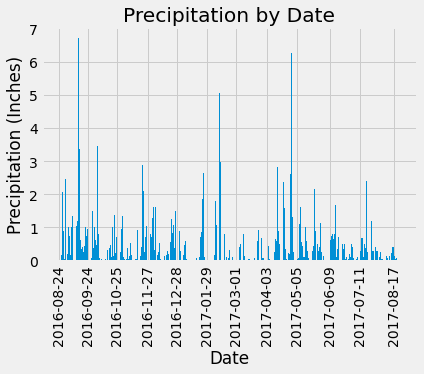

In [73]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = sorted_precip.index
y_axis = sorted_precip['prcp']
plt.bar(x_axis, y_axis)
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title("Precipitation by Date")
plt.xticks(x_axis[::200], rotation='vertical')

In [77]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_mean = round(sorted_precip['prcp'].mean(),2)
prcp_median = round(sorted_precip['prcp'].median(),2)
prcp_mode = round(sorted_precip['prcp'].mode(),2)
prcp_quartiles = sorted_precip['prcp'].quantile([0.25, 0.5, 0.75])
lowerq = prcp_quartiles[0.25]
upperq = prcp_quartiles[0.75]
iqr = upperq - lowerq

print(f"Mean precipitation: {prcp_mean}")
print(f"Median precipitation: {prcp_median}")
print(f"Mode precipitation: {prcp_mode}")
print(f"Interquartile Range: {iqr}")

Mean precipitation: 0.18
Median precipitation: 0.02
Mode precipitation: 0    0.0
dtype: float64
Interquartile Range: 0.13


# Exploratory Station Analysis

In [86]:
# Design a query to calculate the total number stations in the dataset
stations = pd.read_sql("select * from Station", conn)
stations

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [83]:
total_stations = stations['id'].count()
total_stations

9

In [101]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_obs = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(Measurement.station.desc()).all()
station_obs

[('USC00519523', 2669),
 ('USC00519397', 2724),
 ('USC00519281', 2772),
 ('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00513117', 2709),
 ('USC00511918', 1979)]

In [119]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp=session.query(Measurement.tobs, func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519523').all()
max_temp=session.query(Measurement.tobs, func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519523').all()
avg_temp=session.query(Measurement.tobs, func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519523').all()

print(f"The minimum temp is {min_temp[0][0]}.")
print(f"The maximum temp is {max_temp[0][0]}.")
print(f"The average temp is {avg_temp[0][0]}.")

The minimum temp is 56.0.
The maximum temp is 85.0.
The average temp is 75.0.


In [130]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519523').\
    filter(Measurement.date > '2016-08-23').all()
temp_table = pd.DataFrame(temp_data)
temp_table['tobs']

0      79.0
1      80.0
2      84.0
3      81.0
4      80.0
       ... 
331    83.0
332    85.0
333    82.0
334    82.0
335    82.0
Name: tobs, Length: 336, dtype: float64

Text(0.5, 1.0, 'Frequency of Temperatures Reported')

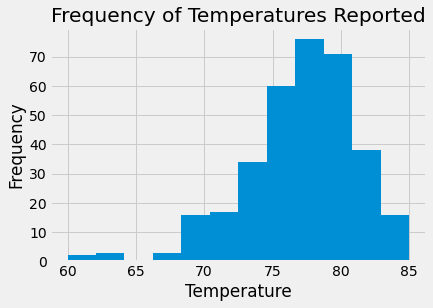

In [131]:
plt.hist(temp_table['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Frequency of Temperatures Reported')

# Close session

In [ ]:
# Close Session
session.close()